# Machine Learning Models - Notebook

# All in One Place: High Value Customer Identification

**All in one place** is an online retail store that sells second-hand products from various brands at lower prices. With just over a year of operation, the marketing team noticed that some customers from their base purchase more expensive products more frequently, contributing significantly to the company's revenue.

Based on this insight, the **marketing team** decided to **launch a loyalty program** for the **top customers** in their base, named Insiders.
Moreover, the Marketing teams lacks the necessary knowledge to identify the customers to join the program. As a result, this task have been assigned to the company's data team, whose should develop a solution and a report to respond the marketing queries below.
Who are the eligible individuals to participate in the program?
How many customers will be part of the group?
What are the main characteristics of these customers?
What percentage of the revenue comes from the selected group?

The company's data team, in accordance with the company's marketing team had combined that, as a first solution, they will use a RFM Matrix to identify the customers.

# 0 - IMPORTS </font>

In [1]:
import re
import warnings

import pandas                as pd
import numpy                 as np
import seaborn               as sns
from matplotlib              import pyplot          as plt
import matplotlib.cm         as cm


# ML Algorithms
import umap.umap_            as umap

from sklearn.manifold        import TSNE
from sklearn                 import mixture as mx
from sklearn                 import preprocessing as pp
from sklearn                 import ensemble      as en
from sklearn                 import decomposition as dd
from sklearn                 import cluster       as cc
from sklearn                 import metrics       as mt
from sklearn                 import ensemble      as en
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster           import hierarchy as hc

warnings.filterwarnings( 'ignore' )

/home/reng/Documents/v_envs/clustering/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 - Helper Functions

In [2]:
def drop_and_rename_duplicate_columns(df):
    """
    Remove duplicate columns resulting from a merge and renames columns to remove the '_x' suffix.
    Removes rows related to canceled or returned invoices: where the value of the `invoice_status_y` column is equal to 'True'.

    Parameters:
    - df (pd.DataFrame): DataFrame resulting from a merge with possible duplicate columns.

    Returns:
    - pd.DataFrame: DataFrame with duplicate columns removed and renamed.
    """

    # Checks if the 'invoice_status_y' column exists and filters where the value is True
    if 'invoice_cancelled_y' in df.columns:
        df = df[~df['invoice_cancelled_y'].fillna(False)]
    
    # Identifies columns with '_x' and '_y' suffixes after the merge
    duplicate_columns = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
    
    # Creates a mapping to keep only one occurrence and rename columns
    cols_to_keep = {}
    for col in duplicate_columns:
        base_name = col[:-2]  # Removes the '_x' or '_y' suffix
        if base_name not in cols_to_keep:
            # Saves the column with the '_x' suffix to keep and rename
            cols_to_keep[base_name] = col

    # Defines the columns to drop, keeping only one of each duplicate pair
    cols_to_drop = set(duplicate_columns) - set(cols_to_keep.values())
    df = df.drop(columns=cols_to_drop)

    # Renames the remaining columns, removing the '_x' suffix
    df = df.rename(columns={old_name: base_name for base_name, old_name in cols_to_keep.items()})

    # Filters the columns, removing invoice_cancelled
    cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']

    return df[cols]


def data_treat(df):
"""
    This function processes and transforms a given DataFrame to clean the data, engineer features, and prepare it for analysis. It performs the following tasks:
    
    1. **Column Renaming and Data Cleaning:**
       - Renames columns for consistency.
       - Removes rows with missing customer IDs.
       - Converts columns to appropriate data types.
       - Removes duplicate entries and filters noisy or irrelevant data.
    
    2. **Invoice and Return Handling:**
       - Identifies and separates canceled or returned invoices.
       - Merges purchase and return data, removing duplicate columns.
    
    3. **Data Cleaning and Filtering:**
       - Excludes products with unit prices of zero.
       - Removes stock codes related to non-product entries.
       - Drops unnecessary columns such as product descriptions.
    
    4. **Feature Engineering:**
       - Computes monetary value (`gross_revenue`) for each transaction.
       - Aggregates customer data to calculate key metrics such as:
         - Total gross revenue per customer.
         - Recency of customer purchases.
         - Number of invoices, products purchased, and distinct products bought.
         - Average ticket size (spending per transaction).
         - Purchase frequency.
    
    5. **Additional Insights:**
       - Calculates quantities of products returned by each customer.
       - Determines the most frequent purchase day of the week and month for each customer.
    
    6. **Data Preparation for Analysis:**
       - Aggregates the processed data into a new DataFrame (`df_ref`), summarizing customer behavior and transaction details.
    
    The function returns the refined and aggregated DataFrame (`df_ref`), which can be used for further analysis or modeling.
"""

    # Rename Columns:
    cols_new = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id','country']
    df.columns = cols_new

    # Removing registers with NaN values
    df= df.loc[~df['customer_id'].isna(),:]

    # Changing data types
    df[ 'invoice_date'] = pd.to_datetime( df['invoice_date'], format='%d-%b-%y') # changing the data on the column invoice data to match the correct data type
    
    df['customer_id'] = df['customer_id'].astype( int ) # changing the data on the column customer id data to match the correct data type
    
    df['country'] = df['country'].astype( str ) # Changing data type from object to string

    # Droping duplicated registers
    df = df.drop_duplicates(subset=None, inplace=False)
    
    # Applying filters to remove noise from the data

    #### REMOVING REGISTERS WHERE THE PURCHASE HAVE BEEN RETURNED OR CANCELLED ####
    # Classifying each invoice as cancelled (True) or not (False) 
    df['invoice_cancelled'] = df['invoice_no'].str.startswith("C") & (df['quantity']<0)
    
    # Separting two datasets:
    df_returns = df[df['invoice_cancelled']] # invoices cancelled
    df_purchases = df[~df['invoice_cancelled']] # invoices not cancelled
    
    # Mergin the above two data sets
    merged_df = df_purchases.merge(df_returns, on=['stock_code','unit_price','customer_id'], how='left')
    
    # Applying function to clean the new data set by removing columns etc.
    df = drop_and_rename_duplicate_columns(merged_df)
    
    # Removing the register from customer 15098 which has an extreme value of gross_revenue
    df = df.drop(df.index[146375]).reset_index(drop=True)
    
    # --- NUMERICAL ATTRIBUTES ---
    
    # Filtering products where price is equal to 0
    df = df.loc[df['unit_price'] > 0, :]
    
    # --- CATEGORICAL ATTRIBUTES ---
    
    # Filtering stock_codes that does not reffers to items
    df = df[~df['stock_code'].isin( ['POST','C2','DOT','PADS','BANK CHARGES'] )]
    
    # Description
    df = df.drop( columns='description', axis=1)


    ##### FEATURE ENGINEERING #####
    
    # data reference
    df_ref = df.drop( ['invoice_no','stock_code','quantity','invoice_date','unit_price','country'],axis=1).drop_duplicates(ignore_index=True)
    
    # Calculus of the monetary value sold
    df.loc[:,'gross_revenue'] = df.loc[:,'quantity'] * df.loc[:,'unit_price']
    df_sold = df.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

    df_ref = pd.merge( df_ref, df_sold, on='customer_id', how='left')
    
    # Recency
    df_recency = df.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
    df_recency['recency_days'] = (df['invoice_date'].max() - df_recency['invoice_date']).dt.days
    df_recency = df_recency[['customer_id','recency_days']].copy()
    df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left')

    # Calculate the quantity of invoices issues for an unique customer
    df_freq = (df.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                    .groupby('customer_id')
                                                    .count()
                                                    .reset_index()
                                                    .rename( columns={'invoice_no':'qty_invoices'}) )
                
    df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

    # Number of products
    df_freqp = (df.loc[:,['customer_id', 'quantity']].groupby('customer_id')
                                                       .sum().reset_index()
                                                       .rename( columns={'quantity':'qty_prod_purchased'}) )

    df_ref = pd.merge(df_ref, df_freqp, on='customer_id', how='left')
   
    # Calculate the range of products per customer
    
    df_prod = ( df.loc[:,['customer_id', 'stock_code']].groupby('customer_id')
                                                    .count()
                                                    .reset_index()
                                                    .rename( columns={'stock_code':'range_of_products'}) )
            
    df_ref = pd.merge(df_ref, df_prod, on='customer_id', how='left')

    # Calculate the average spenses per customer
    df_avg_ticket = ( df.loc[:, ['customer_id','gross_revenue']].groupby('customer_id')
                                                                 .mean()
                                                                 .reset_index()
                                                                 .rename( columns={'gross_revenue':'avg_ticket'}) )

    df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
    
    # Frequency
    df_max = df[['customer_id','invoice_date']].drop_duplicates().groupby('customer_id').max().reset_index() # finding the last date of purchase per customer
    df_min = df[['customer_id','invoice_date']].drop_duplicates().groupby('customer_id').min().reset_index() # finding the last date of purchase per customer

    df_aux = ( df[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                               .groupby('customer_id')
                                                               .agg( max_ =('invoice_date', 'max'),
                                                                     min_ =('invoice_date', 'min'),
                                                                     days_=('invoice_date', lambda x:( (x.max() - x.min() ).days)+1),
                                                                     buy_ =('invoice_no', 'count'))).reset_index()

    # Frequency
    df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

    # Merge
    df_ref = pd.merge(df_ref, df_aux[['customer_id','frequency']], on='customer_id', how='left')
    
    # Quantity of products cancelled
    df_returns = df_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename( columns={'quantity':'qty_returns'})
    df_returns['qty_returns'] = df_returns['qty_returns'] * -1

    df_ref = pd.merge( df_ref, df_returns, on='customer_id', how='left')
    df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0

    # Calculate the average qty of products purchased
    df_ref['avg_qty_products_purchased'] = df_ref['qty_prod_purchased'] / df_ref['qty_invoices']

    # Retrieving the week day for the specific date
    df['week_day']= df['invoice_date'].dt.dayofweek

    # Creating the dataframe with day_week per invoice_no
    aux_02 = df[['invoice_no','customer_id','week_day']].drop_duplicates(ignore_index=True)

    # Calculus of week day most frequent
    aux_03 = aux_02[['customer_id', 'week_day']].groupby('customer_id').apply(lambda x: x.mode().iloc[0]).reset_index(drop=True)

    # Adding the new feature into the data set
    df_ref = pd.merge( df_ref, aux_03, on='customer_id', how='left')

    # Retrieving the week day for the specific date
    df['month']= df['invoice_date'].dt.month

    # Creating the dataframe with day_week per invoice_no
    aux_312 = df[['invoice_no','customer_id','month']].drop_duplicates(ignore_index=True)

    # Calculus of week day most frequent
    aux_3123 = aux_312[['customer_id', 'month']].groupby('customer_id').apply(lambda x: x.mode().iloc[0]).reset_index(drop=True)

    # Adding the new feature into the data set
    df_ref = pd.merge( df_ref, aux_3123, on='customer_id', how='left')

    return(df_ref)

# def data_prep(df):
#     df_one = df.drop( columns=['customer_id'], axis=1 ).copy()
    
#     mms = pp.MinMaxScaler()

#     # Transformer
#     df_one['gross_revenue']              = mms.fit_transform( df_one[['gross_revenue']])
#     df_one['recency_days']               = mms.fit_transform( df_one[['recency_days']])
#     df_one['qty_invoices']               = mms.fit_transform( df_one[['qty_invoices']])
#     df_one['qty_prod_purchased']         = mms.fit_transform( df_one[['qty_prod_purchased']])
#     df_one['range_of_products']          = mms.fit_transform( df_one[['range_of_products']])
#     df_one['avg_ticket']                 = mms.fit_transform( df_one[['avg_ticket']])
#     df_one['frequency']                  = mms.fit_transform( df_one[['frequency']])
#     #df_one['qty_returns']               = mms.fit_transform( df_one[['qty_returns']])
#     df_one['avg_qty_products_purchased'] = mms.fit_transform( df_one[['avg_qty_products_purchased']])
#     #df_one['week_day']                  = mms.fit_transform( df_one[['week_day']])
#     #df_one['month']                     = mms.fit_transform( df_one[['month']])

#     return(df_one)


# 1 - DATA

## 1.1 - LOADING DATA

In [3]:
df = pd.read_csv("../data/raw/Ecommerce.csv")

# drop extra column
df = df.drop( columns=['Unnamed: 8'], axis=1)

## 1.2 - DATA TREATMENT

In [4]:
df1 = data_treat(df)

In [5]:
X = df1.copy()

## 1.3 - DATA PREPARATION

Not needed

In [6]:
# df2 = data_prep(df1)

NameError: name 'data_prep' is not defined

In [ ]:
# X = df2.copy()

# 2 - MACHINE LEARNING ALGORITHMS

## 2.1 - TREE EMBEDDING

In [ ]:
# Creation of an embedding space using randon forest

In [8]:
# Training dataset
X = df1.drop( columns=['gross_revenue'], axis=1 ).copy()
y = df1['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model trainig
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [9]:
df_leaf = pd.DataFrame( rf_model.apply( X ) ) # here i am selecting the datas from the leaf of tree

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

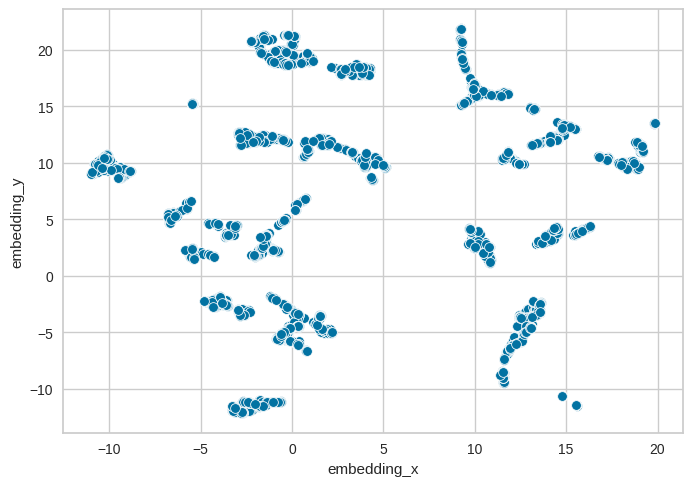

In [10]:
# UMAP 
reducer = umap.UMAP( random_state = 42 )
embedding = reducer.fit_transform( df_leaf )

# Embedding 
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot( 
                 x='embedding_x',
                 y='embedding_y',
                 data=df_tree)

## 2.2 - Applying Machine Learning onto the embedding space to locate the best customers

In [11]:
X = df_tree.copy()

In [12]:
cluster = np.arange(2, 25, 1)

### 2.2.1 - K-Means

In [13]:
kmeans_list = []
for k in cluster:
    # Model Definition
    kmeans_model = cc.KMeans( n_clusters=k )

    # Model Training
    kmeans_model.fit( X )
    # Model Predict
    labels = kmeans_model.predict( X )

    # Model Performance
    sil = mt.silhouette_score( X, labels, metric='euclidean')
    kmeans_list.append( sil )

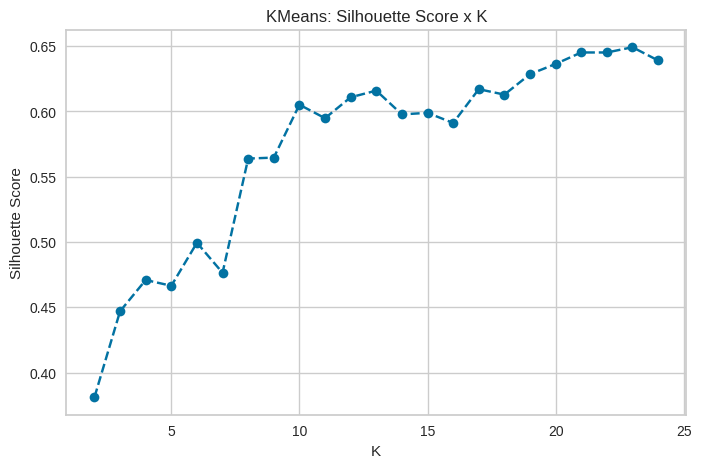

In [14]:
plt.figure( figsize=(8, 5) )
plt.plot( cluster, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title('KMeans: Silhouette Score x K');

### 2.2.2 - Gaussiann Mixture Model

AIC - Data Adjustments
BIC - Parameters Adjustments

In [15]:
gmm_list = [] 
for k in cluster:
    # Model Definition
    gmm_model = mx.GaussianMixture( n_components=k )
    
    # Model Training
    gmm_model.fit( X )

    # Model Predict
    labels = gmm_model.predict( X )

    # Model Performance
    gmm_sil = mt.silhouette_score( X, labels, metric='euclidean')
    gmm_list.append( gmm_sil )

Text(0.5, 1.0, 'GMM: Silhouette Score x K')

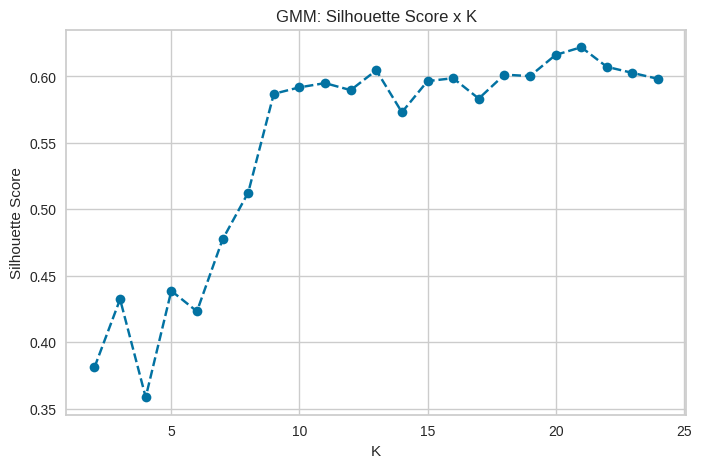

In [16]:
plt.figure( figsize=(8, 5) )
plt.plot( cluster, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title('GMM: Silhouette Score x K')

### 2.2.3 - Hierarchical Clustering

In [17]:
# Model Definition and Training
hc_model = hc.linkage( X, 'ward')

[]

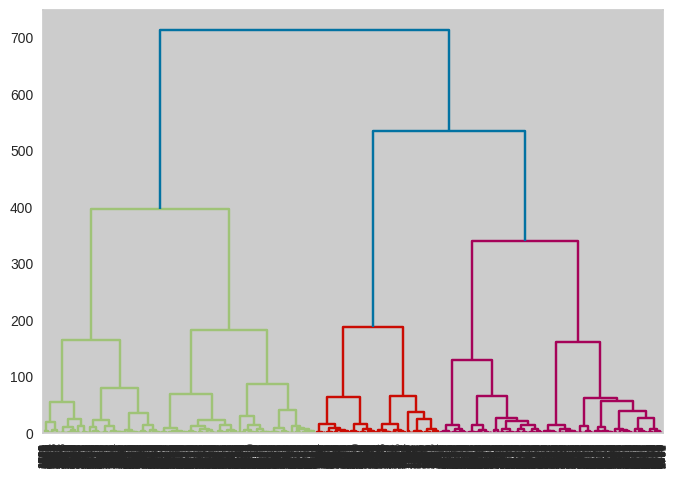

In [18]:
hc.dendrogram(
              hc_model,
              leaf_rotation=90,
              leaf_font_size=8
)

plt.plot()

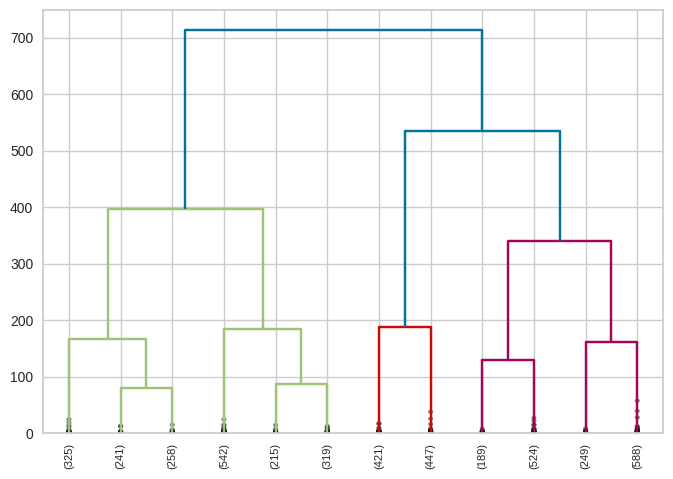

In [19]:
hc.dendrogram(
            hc_model,
            truncate_mode='lastp',
            p=12,
            leaf_rotation=90,
            leaf_font_size=8,
            show_contracted=True
)
plt.show()

### 2.2.4 - Hierarchical Cluster Silhouette

In [20]:
hc_list = []
for k in cluster:
    # Model Definition and Training
    hc_model = hc.linkage( X, 'ward' )

    # Model Predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

Text(0.5, 1.0, 'HC: Silhouette Score x K')

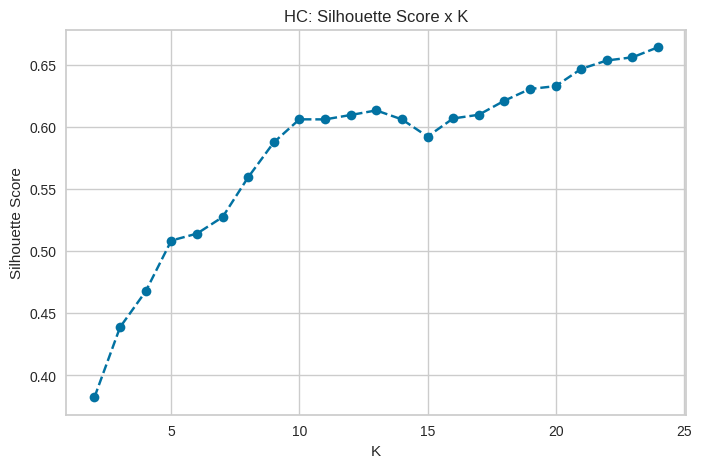

In [21]:
plt.figure( figsize=(8, 5) )
plt.plot( cluster, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title('HC: Silhouette Score x K')

In [22]:
hc_list

[np.float32(0.38244256),
 np.float32(0.43881544),
 np.float32(0.46766424),
 np.float32(0.5085152),
 np.float32(0.5140899),
 np.float32(0.52738583),
 np.float32(0.5594559),
 np.float32(0.5875194),
 np.float32(0.60608405),
 np.float32(0.6060164),
 np.float32(0.6095559),
 np.float32(0.61324835),
 np.float32(0.6060277),
 np.float32(0.5922233),
 np.float32(0.6067838),
 np.float32(0.6097308),
 np.float32(0.6210565),
 np.float32(0.6304924),
 np.float32(0.63278115),
 np.float32(0.6466699),
 np.float32(0.6534355),
 np.float32(0.65598506),
 np.float32(0.66409606)]

### 2.2.5 - Silhouette Analysis

 For K = 2. Silhouette Score: 0.38244256377220154
 For K = 3. Silhouette Score: 0.4388154447078705
 For K = 4. Silhouette Score: 0.4676642417907715
 For K = 5. Silhouette Score: 0.5085151791572571
 For K = 6. Silhouette Score: 0.5140898823738098
 For K = 7. Silhouette Score: 0.5273858308792114
 For K = 8. Silhouette Score: 0.5594558715820312
 For K = 9. Silhouette Score: 0.5875194072723389
 For K = 10. Silhouette Score: 0.6060840487480164
 For K = 11. Silhouette Score: 0.6060163974761963
 For K = 12. Silhouette Score: 0.6095559000968933
 For K = 13. Silhouette Score: 0.613248348236084
 For K = 14. Silhouette Score: 0.6060277223587036
 For K = 15. Silhouette Score: 0.5922232866287231
 For K = 16. Silhouette Score: 0.6067838072776794
 For K = 17. Silhouette Score: 0.6097307801246643
 For K = 18. Silhouette Score: 0.6210564970970154
 For K = 19. Silhouette Score: 0.6304923892021179
 For K = 20. Silhouette Score: 0.6327811479568481
 For K = 21. Silhouette Score: 0.6466699242591858
 For K =

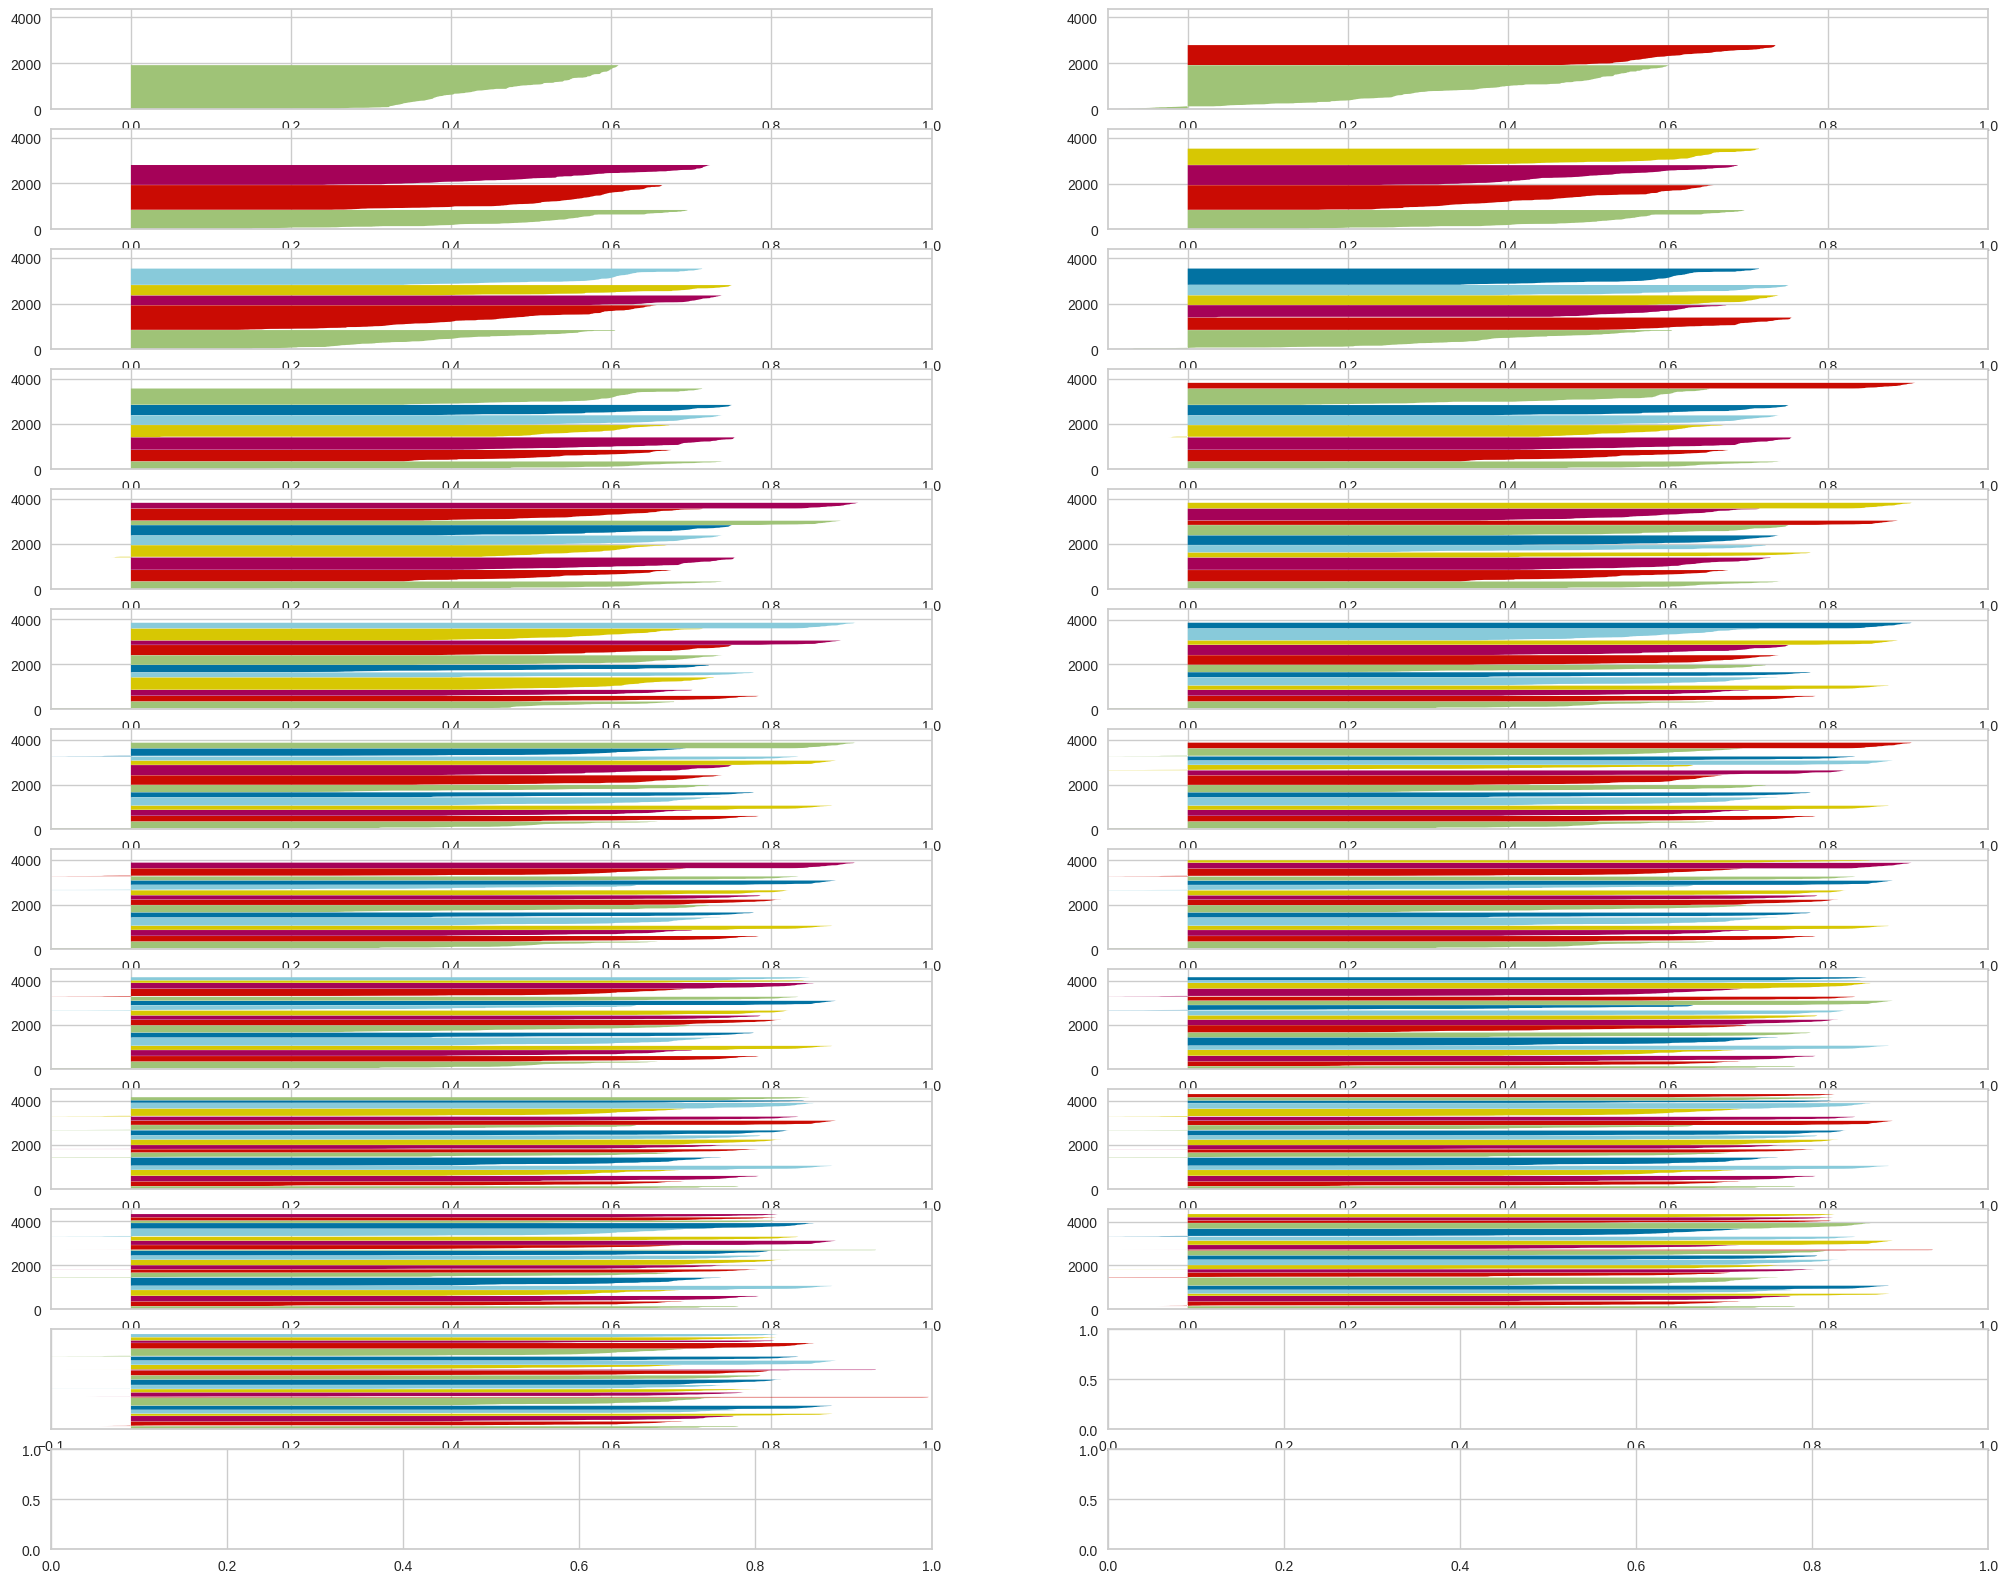

In [23]:
fig, ax = plt.subplots( 13, 2 )
fig.set_size_inches( 25, 20 )

for k in cluster:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [-0.1, 1] )
    ax[q-1, mod].set_ylim( [0, len( X ) + ( k+1 )*10] )
    
    # Model Definition and Training
    hc_model = hc.linkage( X, 'ward')

    # Model Predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust')
    
    # Performance
    ss = mt.silhouette_score( X, labels, metric='euclidean')
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    
    samples_silhouette_values = mt.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):
        # Select Clusters
        ith_samples = samples_silhouette_values[ labels == i ]

        # Size Clusters
        size_cluster_i = ith_samples.shape[0]
        
        # Sort values
        ith_samples.sort()    

        # Limits
        y_upper = y_lower + size_cluster_i

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples )
        
        y_lower = y_upper + 10 
     
        cmap = cm.get_cmap( 'Spectral')
        color = cmap( i/k )
    
    
    
    
ax[q-1, mod].set_yticks([])
ax[q-1, mod].set_xticks([-0.1, 0.2, 0.4, 0.6, 0.8, 1])

### 2.2.6 - Results

In [24]:
df_results = pd.DataFrame(
                          {'KMeans': kmeans_list,
                           'GMM': gmm_list,
                           'HC':hc_list}
).T

df_results.columns = cluster

In [25]:
df_results.style.highlight_max( color='lightgreen', axis=1 ) #identifying the highest value for each ml model

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.381058,0.446951,0.470868,0.466443,0.499407,0.476390,0.563922,0.564649,0.605188,0.594837,0.610875,0.615973,0.597748,0.598961,0.591199,0.617071,0.612916,0.628556,0.636413,0.645217,0.645193,0.649226,0.639094
GMM,0.381058,0.432346,0.358632,0.438684,0.423212,0.477327,0.512523,0.586907,0.591788,0.594972,0.589696,0.604595,0.573037,0.596491,0.598668,0.583338,0.601322,0.600267,0.616176,0.621977,0.607229,0.602658,0.598167
HC,0.382443,0.438815,0.467664,0.508515,0.514090,0.527386,0.559456,0.587519,0.606084,0.606016,0.609556,0.613248,0.606028,0.592223,0.606784,0.609731,0.621056,0.630492,0.632781,0.646670,0.653436,0.655985,0.664096


## 3 - MACHINE LEARNING AFTER TUNING

### 3.1 - K-MEANS

In [ ]:
# Model Definition
k = 24
kmeans = cc.KMeans( init='random', n_clusters=k, n_init=300, random_state=42 )

# Model Trainin
kmeans.fit( X )

# Model Prediction
labels = kmeans.labels_

### 3.2 - GMM

In [ ]:
k = 18
# Model Definition
gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state=42  )
    
# Model Training
gmm_model.fit( X )

# Model Predict
labels = gmm_model.predict( X )

### 3.3 - HC

In [26]:
k = 24
# Model Definition and Training
hc_model = hc.linkage( X, 'ward' )

# Model Predict
labels = hc.fcluster( hc_model, k, criterion='maxclust' )

## 4 - CLUSTER ANALYSIS

In [27]:
df9 = X.copy()
df9['cluster'] = labels

## 4.1 - VIZUALIZATION INSPECTION

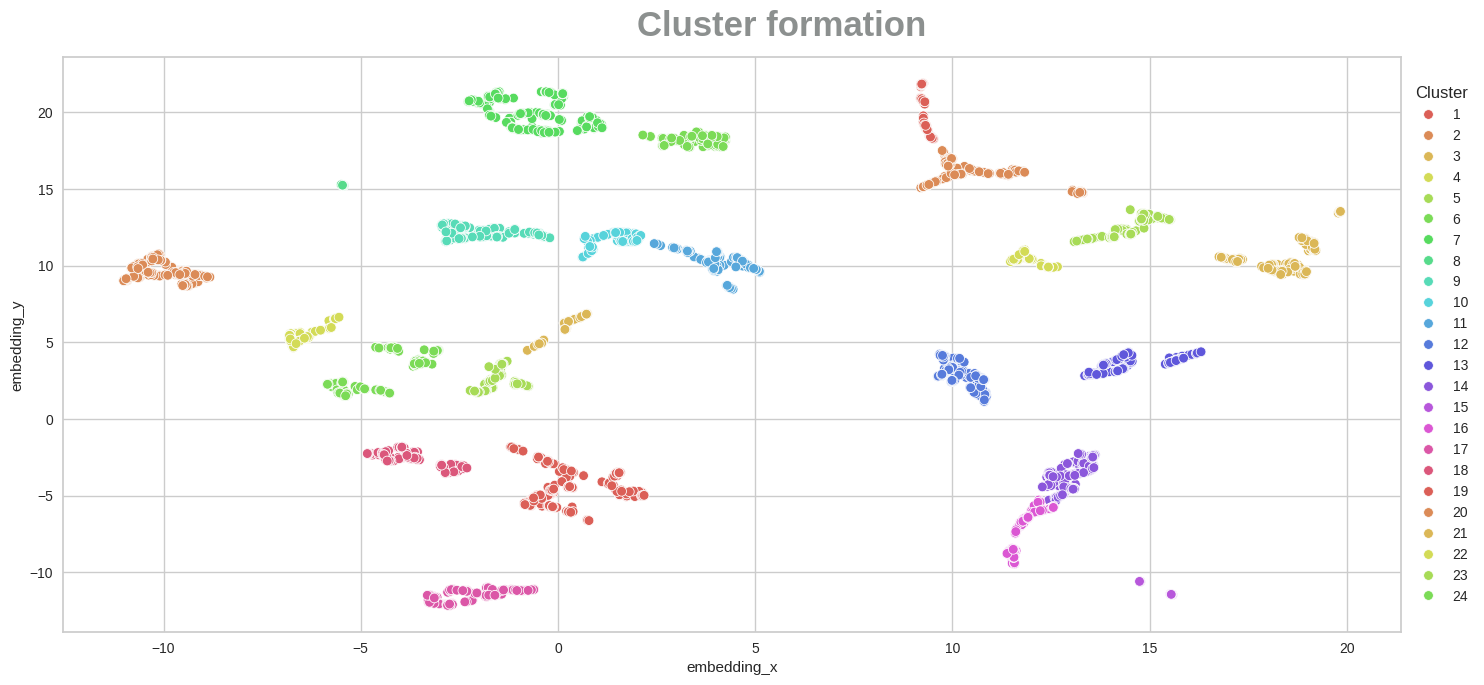

In [28]:
# Definindo a figura e os eixos para o gráfico de dispersão
fig, ax = plt.subplots(figsize=(15, 7))

# Gráfico de dispersão com legenda de cores para clusters
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette=sns.color_palette("hls", 18), ax=ax)

# Título
plt.text(x=2, y=25, s='Cluster formation', fontsize=25, color='#8C908F', weight='bold')

# Movendo a legenda para fora do gráfico
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Cluster")  # Ajuste de posição da legenda

fig.tight_layout()
plt.show()

## 4.4 - CLUSTER PROFILE

In [29]:
df4 = df1.copy()
df4['cluster'] = labels
df4.head()

,customer_id,gross_revenue,recency_days,qty_invoices,qty_prod_purchased,range_of_products,avg_ticket,frequency,qty_returns,avg_qty_products_purchased,week_day,month,cluster
0,17850,4046.51,372,34,1191,204,19.835833,17.000000,37.0,35.029412,2.0,11.0,13
1,13047,2392.96,31,10,1159,130,18.407385,0.029155,36.0,115.900000,1.0,11.0,3
2,12583,6507.44,2,15,4854,225,28.921956,0.040323,51.0,323.600000,1.0,11.0,16
3,13748,948.25,95,5,439,28,33.866071,0.017921,0.0,87.800000,2.0,4.0,1
4,15291,4396.00,25,15,1949,96,45.791667,0.042980,29.0,129.933333,6.0,3.0,12


In [30]:
df4[['gross_revenue', 'cluster']].groupby('cluster').sum().reset_index().sort_values(by='gross_revenue', ascending=False)

,cluster,gross_revenue
14,15,1985016.74
15,16,1620844.47
13,14,872699.22
11,12,636436.22
2,3,434622.31
12,13,386219.59
1,2,250407.25
6,7,244489.22
4,5,224908.47
5,6,167096.88


In [31]:
# Number of Customer
df_cluster = df4[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross Revenue
df_avg_gross_revenue = df4[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg Recency Days
df_avg_recency_days = df4[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg Qty Products
df_qty_product = df4[['qty_prod_purchased', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qty_product, how='inner', on='cluster')

# Avg Frequency
df_freq = df4[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_freq, how='inner', on='cluster')

# Avg Returns
#df_ret = df4[['qty_returns', 'cluster']].groupby('cluster').mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_ret, how='inner', on='cluster')

df_cluster.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qty_prod_purchased,frequency
14,15,31,0.717925,64032.798065,11.193548,38463.193548,0.141750
15,16,201,4.654933,8063.902836,25.218905,5182.651741,0.105056
13,14,215,4.979157,4059.066140,27.762791,2452.260465,0.064436
11,12,238,5.511811,2674.101765,38.903361,1700.605042,0.051995
12,13,183,4.238073,2110.489563,40.639344,1305.814208,0.176945
2,3,241,5.581288,1803.412075,39.663900,965.282158,0.037096
4,5,164,3.798055,1371.393110,58.176829,952.780488,0.144487
1,2,207,4.793886,1209.696860,54.531401,630.314010,0.096675
3,4,94,2.176934,1170.185319,66.500000,786.723404,0.217577
0,1,118,2.732747,977.126017,53.703390,425.652542,0.029941


In [32]:
df4[df4['cluster']==15].head()

,customer_id,gross_revenue,recency_days,qty_invoices,qty_prod_purchased,range_of_products,avg_ticket,frequency,qty_returns,avg_qty_products_purchased,week_day,month,cluster
7,15311,39014.08,0,90,25032,2135,18.273574,0.240642,474.0,278.133333,3.0,1.0,15
11,16029,34195.61,38,48,19743,147,232.623197,0.142857,6476.0,411.312500,1.0,9.0,15
14,17511,64646.58,2,30,49719,764,84.615942,0.080645,1537.0,1657.300000,1.0,12.0,15
17,13408,26932.22,1,61,15806,455,59.191692,0.163539,113.0,259.114754,1.0,11.0,15
34,13694,61069.58,3,48,60246,545,112.054275,0.129380,1413.0,1255.125000,1.0,8.0,15
